# Simple Moving Average Backtest

Import all the dependencies required for the following code:

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import math

## Variable Setup

In the following set the variables up you would like to run the SMA backtest for (dates are of the format 'yyyy-mm-dd' and the window size is in days):

In [3]:
ticker_symbol = 'TSLA'
start_date = '2019-01-01'
end_date = '2020-11-30'
sma_window_size = 50

## Get the Stock Price Data

Get the stock price data as defined by the previous variables and visualise to check it:

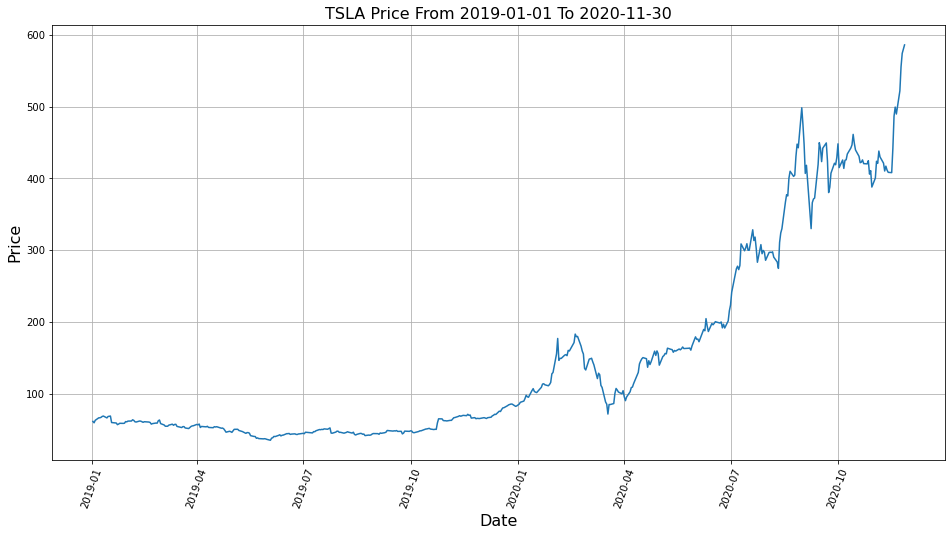

In [4]:
stock_price_data = yf.Ticker(ticker_symbol)
hist = stock_price_data.history(start=start_date, end=end_date)

plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])
plt.xticks(rotation=70)
plt.grid()
plt.title('{0} Price From {1} To {2}'.format(ticker_symbol, start_date, end_date), fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.show()

## Calculate the Simple Moving Average Data

The following line of code calculates the simple moving average of the stock price. It uses the stock close price and a rolling window size equal to sma_window_size that was set above to calculate the mean stock close price. So what this is doing is for any day ```X```, the stock close prices from day ```X - sma_window_size``` to ```X``` are used to calculate a mean for day ```X```.

Note that if ```X - sma_window_size < 0``` (i.e. before the start of the stock data) then a mean value is not calculated for day ```X```.

The results of this calculation are stored in the a new column in the dataframe called 'SMA'.

In [5]:
hist['SMA'] = hist['Close'].rolling(sma_window_size).mean()

The following plots the original stock close price data and the SMA data just calculateed so that we can check it.

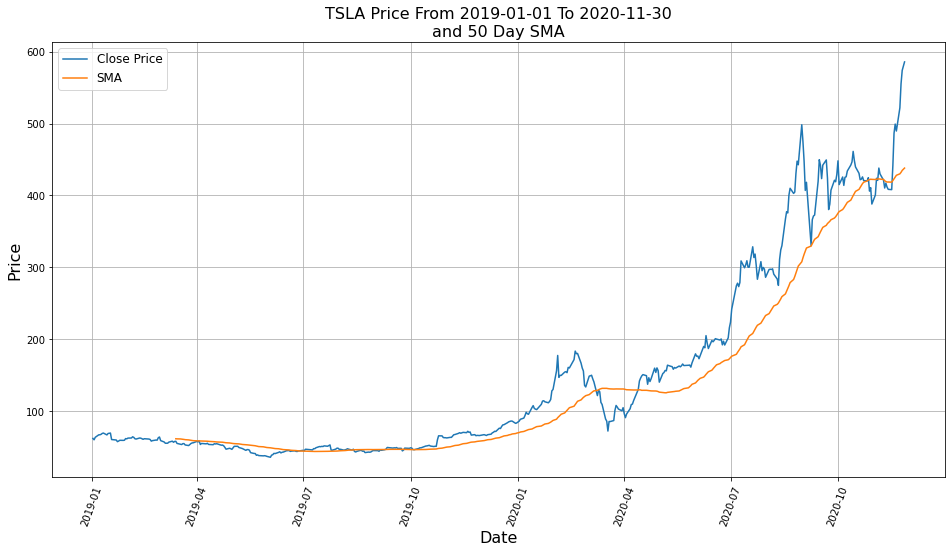

In [6]:
plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])
plt.plot(hist.index, hist['SMA'])
plt.xticks(rotation=70)
plt.grid()
plt.title('{0} Price From {1} To {2}\nand {3} Day SMA'.format(\
      ticker_symbol, start_date, end_date, sma_window_size), fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend(['Close Price', 'SMA'], loc='upper left', fontsize=12)
plt.show()

## Backtest

Now that we've got our stock and SMA data we can backtest our algorithm. Backtesting is the process of applying our trading algorithm over historic data, in chronological order (effectively playing the stock data through the algorithm), to see how well it performed.

In this case, our trading algorithm uses the stock and SMA data in the following way:
* If we don't currently hold the stock and the stock price > the SMA for a given day then buy the stock
* If we currently hold the stock and the stock price < the SMA for given day then sell the stock

This is what the following block of code implements, along with the calculation of some useful stats we can use to analysis the performance of the algorithm with the stock.

In [7]:
backtest = pd.DataFrame(columns=['BuyDate', 'BuyPrice', 'SellDate', 'SellPrice',\
    'SellBuyDiff', 'SellBuyPercentageDiff', 'CumulativeSellBuyDiff', 'SellFirstBuyPercentageDiff'])

currently_holding = False

counter = 0

buy_date = None
buy_price = None
sell_date = None
sell_price = None

first_buy_price = None

for i, row in hist.iterrows():
    if not currently_holding and not math.isnan(row['SMA']) and row['Close'] > row['SMA']:
        buy_date = i
        buy_price = row['Close']
        currently_holding = True
        
        if first_buy_price == None:
            first_buy_price = buy_price
    if currently_holding and not math.isnan(row['SMA']) and row['Close'] < row['SMA']:
        sell_date = i
        sell_price = row['Close']
        
        backtest.at[i, 'BuyDate'] = buy_date
        backtest.at[i, 'BuyPrice'] = buy_price
        backtest.at[i, 'SellDate'] = sell_date
        backtest.at[i, 'SellPrice'] = sell_price
        backtest.at[i, 'SellBuyDiff'] = sell_price - buy_price
        backtest.at[i, 'SellBuyPercentageDiff'] = ((backtest.at[i, 'SellBuyDiff']) / buy_price) * 100
        backtest.at[i, 'CumulativeSellBuyDiff'] = backtest['SellBuyDiff'].sum()
        backtest.at[i, 'SellFirstBuyPercentageDiff'] = ((sell_price - first_buy_price) / first_buy_price) * 100
        
        currently_holding = False
        counter += 1
          
print(backtest)

                        BuyDate BuyPrice             SellDate SellPrice  \
2019-08-12  2019-06-28 00:00:00   44.692  2019-08-12 00:00:00    45.802   
2019-08-14  2019-08-13 00:00:00       47  2019-08-14 00:00:00    43.924   
2019-09-24  2019-09-10 00:00:00   47.108  2019-09-24 00:00:00    44.642   
2019-10-04  2019-09-26 00:00:00   48.512  2019-10-04 00:00:00    46.286   
2020-03-09  2019-10-07 00:00:00   47.544  2020-03-09 00:00:00     121.6   
2020-10-28  2020-04-13 00:00:00   130.19  2020-10-28 00:00:00    406.02   
2020-11-04  2020-11-03 00:00:00    423.9  2020-11-04 00:00:00    420.98   
2020-11-09  2020-11-05 00:00:00   438.09  2020-11-09 00:00:00    421.26   

           SellBuyDiff SellBuyPercentageDiff CumulativeSellBuyDiff  \
2019-08-12        1.11               2.48366                  1.11   
2019-08-14      -3.076              -6.54468                -1.966   
2019-09-24      -2.466              -5.23479              -4.43201   
2019-10-04      -2.226              -4.58856

The following visualises some of our useful stats previously calculated by stock sale date. These give a useful overview of how well the previous algorithm performed with the stock data loaded.

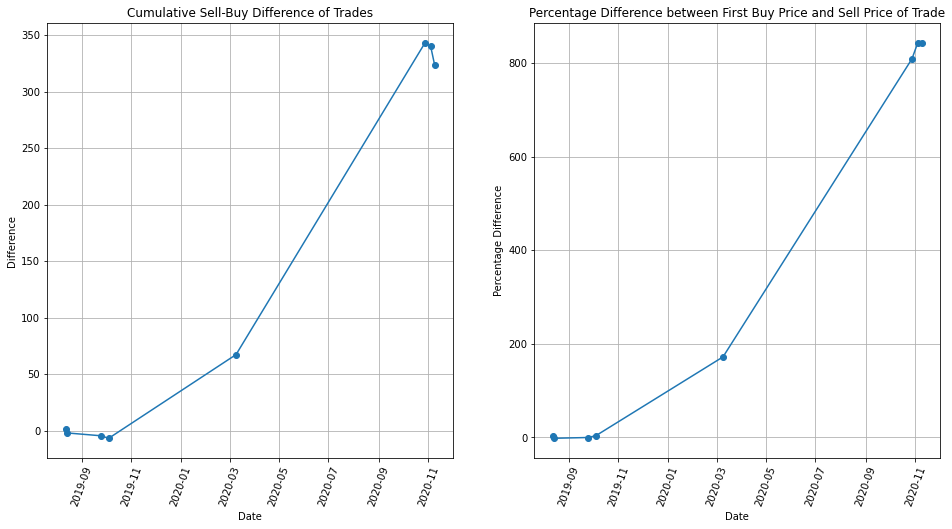

In [8]:
fig = plt.figure()
fig.set_size_inches(16, 8)

plt.subplot(1, 2, 1)
plt.title('Cumulative Sell-Buy Difference of Trades')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.plot(backtest['SellDate'], backtest['CumulativeSellBuyDiff'], 'o-')
plt.xticks(rotation=70)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Percentage Difference between First Buy Price and Sell Price of Trade')
plt.xlabel('Date')
plt.ylabel('Percentage Difference')
plt.plot(backtest['SellDate'], backtest['SellFirstBuyPercentageDiff'], 'o-')
plt.xticks(rotation=70)
plt.grid()

plt.show()

Finally, the below shows the original stock close price data used (blue) with an overlay (red) showing where stock ownership would have occurred under the previous algorithm.

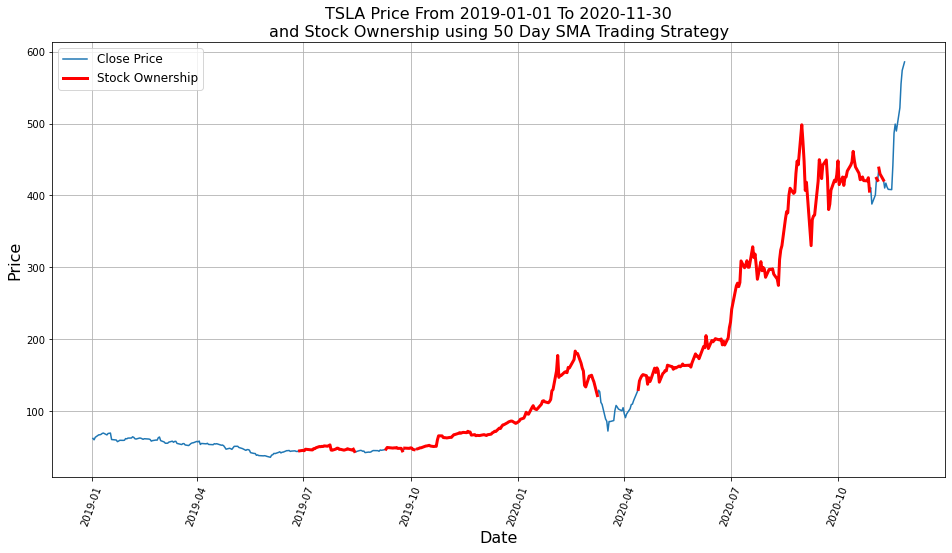

In [9]:
plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])

for i, row in backtest.iterrows():
    hist_slice = hist.loc[hist.index >= row['BuyDate']]
    hist_slice = hist_slice.loc[hist_slice.index <= row['SellDate']]
    plt.plot(hist_slice.index, hist_slice['Close'], 'r', linewidth=3)

plt.title('{0} Price From {1} To {2}\nand Stock Ownership using {3} Day SMA Trading Strategy'.format(\
      ticker_symbol, start_date, end_date, sma_window_size), fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend(['Close Price', 'Stock Ownership'], loc='upper left', fontsize=12)

plt.xticks(rotation=70)
plt.grid()
plt.show()